#### Разработка модели компьютерного зрения для классификации изображений тарелок на две категории: «чистая» и «грязная».


Цель: Обучить модель, которая будет классифицировать тарелки как чистые или грязные.

Метрика: accuracy (точность).

Тип задачи: бинарная классификация изображений.

Подход: использовать предобученную модель (transfer learning), т.к. обучающей выборки мало.

In [763]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import os                                     #Работа с папками и файлами
import torch                                  #работа с тензорами и нейросетями.
from torchvision import datasets              #Умеет загружать изображения из папок
from torchvision import transforms            # Преобразует изображения (изменение размера, нормализация)
from torch.utils.data import DataLoader       #Разбивает данные на batch
from torch.utils.data import random_split     #Разбивает данные на batch
import matplotlib.pyplot as plt               #Для отображения картинок
from torchvision import models                #Предобученные модели, такие как ResNet, VGG, MobileNet и др
from torch import nn                          #Модули для построения нейросетей (например, nn.Linear, nn.Conv2d, nn.ReLU).
from torch import optim                       # Оптимизаторы: SGD, Adam и др.
from torch.utils.data import DataLoader       #Загрузка данных по батчам, перемешивание, итерация по датасету.
from PIL import Image                         # Работа с изображениями (открытие, преобразование, чтение/запись).

In [764]:

# Автоматически использовать GPU, если он доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

Используемое устройство: cpu


In [765]:
## Блок для загрузки на kaggle

# # Путь к zip file
# zip_path = "/kaggle/input/platesv2/plates.zip"
# output_dir = "/kaggle/working/plates"  # output path

# # Создать папку, если ее нет
# os.makedirs(output_dir, exist_ok=True)

# # Распаковка
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(output_dir)

# print("Выполнено:", output_dir)


# # Укажем пути к папкам
# train_dir = "/kaggle/working/plates/train"  # Обучающая выборка
# test_dir = "/kaggle/working/plates/test"    # Тестовая выборка

### 2. Подготовка и предобработка данных

In [766]:

# Укажем пути к папкам (данные сохранены локально на ПК)
train_dir = 'plates/train'  # Обучающая выборка
test_dir = 'plates/test'    # Тестовая выборка

In [767]:

# Преобразования (аугментация + нормализация) для обучающей выборки
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                  # Изменим размер всех изображений под модель ResNet18 - она обучалась на таких.
    transforms.RandomHorizontalFlip(),              # Случайное отражение по горизонтали
    transforms.RandomVerticalFlip(),                # Случайное отражение по вертикали
    transforms.RandomRotation(15),                  # Случайное вращение
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # Изменение цветовых параметров
    transforms.RandomAdjustSharpness(sharpness_factor=2.0), # случайным образом изменяет резкость изображения
    transforms.ToTensor(),                          # Перевод в тензор
    transforms.Normalize([0.485, 0.456, 0.406],     # Нормализация, как в ImageNet. Стандартные для предобученных моделей (например, ResNet).
                         [0.229, 0.224, 0.225])
])

In [768]:

# Преобразования для валидационной выборки. Без аугментации, т.к. валидация проходит на чистых данных.
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

Dataset — это объект, который:

- знает, где хранятся данные (например, картинки или таблицы)

- знает, как их загружать

- умеет отдавать данные по одному элементу: картинка + метка (label)

Dataset преобразует изображения в тензоры и отдаёт их нейросети по одному, готовыми к обучению. 

Нейросеть сама не умеет читать изображения с диска, она ожидает: "дай мне тензоры (числа), а не файлы!"

##### ImageFolder:
- Сканирует папки с картинками
- Назначает каждой папке номер класса (0, 1, 2, ...)
- Запоминает путь к каждому изображению и как его преобразовать (resize, аугментации и т.д.)

In [769]:
## Блок разделения данных на train и val без кросс-валидации.

# # Создание датасета.
# # Загружаем все изображения из папки train_dir. 
# # К каждому изображению сразу применяется преобразования train_transforms
# full_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

# # Делим на обучающую и валидационную (например, 80/20)
# train_size = int(0.8 * len(full_dataset))
# val_size = len(full_dataset) - train_size
# train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# # Устанавливаем трансформации отдельно для валидации
# # чтобы на валидации применялись другие трансформации, а не те, что на обучении.
# val_dataset.dataset.transform = val_transforms

In [770]:
## Кросс-валидационное разбиение данных на train и val

full_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-кратная кросс-валидация

# Создаём список индексов от 0 до len(full_dataset) - 1.
# Эти индексы будут использоваться для разбиения данных на обучающую и валидационную части в каждом фолде.
dataset_indices = list(range(len(full_dataset)))

##### Валидационная выборка (проверка на каждом шаге обучения)
Основная цель: Настройка гиперпараметров модели и предотвращение переобучения (overfitting).

##### Тестовая выборка 
используется для оценки финальной производительности модели.

In [771]:
# Проход по фолдам и вывод номера текущего фолда в кросс-валидации.

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f"\n ФОЛД {fold+1} ")


 ФОЛД 1 

 ФОЛД 2 

 ФОЛД 3 

 ФОЛД 4 

 ФОЛД 5 


In [772]:
# Создаём подмножества с разными преобразованиями
train_subset = torch.utils.data.Subset(full_dataset, train_idx)
val_subset = torch.utils.data.Subset(full_dataset, val_idx)

# Меняем трансформации вручную
train_subset.dataset.transform = train_transforms
val_subset.dataset.transform = val_transforms

In [773]:

# Создаем DataLoader
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False)

DataLoader — это инструмент в PyTorch, который разбивает данные на батчи, перемешивает (shuffle) их (если нужно) и подаёт на вход модели. Он упрощает загрузку данных для обучения, обрабатывая их по частям (батчам), а не сразу всё.

*Батч — это часть обучающей выборки, которая подаётся в модель одновременно, одним "куском".*

*Эпоха — это полный проход по всем тренировочным данным один раз. (всего 20 картинок. За эпоху пройдется обучение по 20 картинкам)*

*Каждый раз, когда батч формируется (внутри DataLoader), на изображения случайно применяются аугментации*

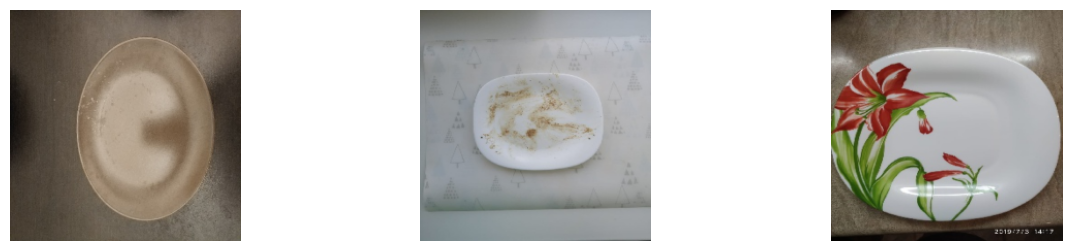

In [774]:

# Визуализация изображений из train_loader
def show_batch(loader):
    images, labels = next(iter(loader))             # Извлекаем изображения и метки из первого батча
    images = images[:3]                             # Покажем только первые 3 изображений
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))  # Создаём график для отображения 6 изображений
    for i in range(3):
        img = images[i].permute(1, 2, 0)            # Переводим тензор из (C, H, W) в (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # "Разнормализация"
        img = img.clip(0, 1)                        # Ограничиваем значения пикселей в диапазоне [0, 1]
        axs[i].imshow(img)                          # Отображаем изображение на графике
        axs[i].axis('off')                          # Убираем оси
    plt.show()                                      # Показываем все изображения

show_batch(train_loader)


### 3. Выбор модели и архитектура
Используем предобученную модель: ResNet18

ResNet18 уже обучалась на огромном датасете ImageNet. Это значит, что она "знает", как распознавать базовые формы, текстуры и объекты. Мы используем это как «базу знаний», чтобы не обучать всё с нуля.


In [775]:

# Загружаем предобученную ResNet18, обученную на ImageNet
model = models.resnet18(pretrained=True)

# pretrained=True - Загружаем предобученные веса этой сети, обученные на датасете ImageNet

Если не заморозить слои, модель будет обновлять все веса, а у нас мало данных. Это приведёт к переобучению.
Замораживая веса, мы фиксируем «знания» модели, и обучаем только последний слой, чтобы он научился отличать чистые от грязных тарелок.

In [776]:

# Замораживаем все веса, чтобы они не обучались

for param in model.parameters():
    param.requires_grad = False

Нам нужно знать, сколько признаков приходит на вход в последний слой, чтобы заменить его корректно.

In [777]:

# Получаем количество входных признаков последнего слоя
num_features = model.fc.in_features
print(num_features)

512


Заменяем исходный fc слой на новый, который принимает на вход те же 512 признаков и выдаёт 2 выхода — по одному на каждый класс (чистая / грязная).

Теперь модель вместо 1000 классов предсказывает только 2 — под нашу задачу.

model.fc - это имя последнего слоя в ResNet-18 в PyTorch. fc — это сокращение от fully connected, то есть полносвязный слой. Это последний слой, который выдаёт результат классификации.

In [778]:
# Заменяем последний полносвязный слой под 2 класса: чистая/грязная
model.fc = nn.Linear(num_features, 2)

In [779]:
# Переносим модель на выбранное ранее устройство (GPU или CPU).
model = model.to(device)

### 4. Обучение модели

CrossEntropyLoss измеряет, насколько неверно модель предсказала классы, сравнивая предсказанные вероятности и истинные метки классов.

Кросс-энтропия — это метрика, которая измеряет, насколько предсказания модели совпадают с настоящими метками классов.
Она штрафует модель, если она уверена в неправильном ответе, и поощряет за уверенность в правильном.

In [780]:
# Кросс-энтропия — стандартная функция потерь для классификации
criterion = nn.CrossEntropyLoss()

Adam — это один из самых популярных оптимизаторов в машинном обучении.

Он является улучшенной версией градиентного спуска и использует две ключевые идеи для улучшения процесса обучения:

- Адаптивное изменение шага обучения для каждого параметра. Это помогает алгоритму быстрее сходиться и уменьшить колебания.

- Использование моментов: Adam отслеживает как первый момент (среднее градиентов), так и второй момент (дисперсия градиентов), что помогает стабилизировать обучение.

model.fc.parameters() — оптимизировать параметры только последнего слоя модели.

In [781]:
# обучаем только последний слой модели (model.fc), остальные заморожены.

optimizer = optim.Adam(model.fc.parameters(), lr=0.0005, weight_decay=0.02)

In [782]:
num_epochs = 100

In [783]:
# Хранение истории обучения
# Создадим списки, чтобы сохранять значения ошибки (loss) и точности (accuracy) после каждой эпохи.
# Обнуление истории обучения на каждый фолд
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

## Блок для ранней остановки (не показал свою эффективность на данном датасете)
# best_val_loss = float('inf')  # наилучшая пока что ошибка на валидации
# patience = 5                  # сколько эпох ждать улучшения
# counter = 0                   # счётчик эпох без улучшения

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:                       #Берём по очереди батчи 
        images, labels = images.to(device), labels.to(device) #Перенос данных на устройство

        optimizer.zero_grad()                # Удаляем старые градиенты (иначе они будут суммироваться с новыми).
        outputs = model(images)              # получаем предсказания модели.
        loss = criterion(outputs, labels)    # сравниваем предсказания и реальные метки, считаем ошибку (loss).
        loss.backward()                      # считаем градиенты.
        optimizer.step()                     # обновляем веса модели по этим градиентам.

        # Накопление статистики
        running_loss += loss.item() * images.size(0)        # превращаем тензор с ошибкой в обычное число и умножаем на количество изображений в текущем батче.
        _, preds = torch.max(outputs, 1)                    # получаем предсказанный класс (с наибольшей вероятностью).
        running_corrects += (preds == labels).sum().item()  # считаем, сколько предсказаний были верными.

    # Средние значения за эпоху. Считаем среднюю ошибку и точность по всем изображениям в обучающем наборе.
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    # Сохраняем результаты/ Добавляем данные для графиков
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

  # ВАЛИДАЦИЯ
    model.eval()  # переводим модель в режим оценки
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():  # отключаем подсчёт градиентов
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += (preds == labels).sum().item()


    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # Печатаем результаты
    print(f"Эпоха {epoch+1}/{num_epochs}")
    print(f"  Обучение   — Потеря: {epoch_loss:.4f}, Точность: {epoch_acc:.4f}")
    print(f"  Валидация — Потеря: {val_epoch_loss:.4f}, Точность: {val_epoch_acc:.4f}")

# # EARLY STOPPING 
#     if val_epoch_loss < best_val_loss:
#         best_val_loss = val_epoch_loss
#         torch.save(model.state_dict(), f'best_model_fold{fold + 1}.pth')
#         counter = 0
#         print("Улучшение модели — сохраняем!")
#     else:
#         counter += 1
#         print(f"Нет улучшения. Плохих эпох подряд: {counter}")
#         if counter >= patience:
#             print("Ранняя остановка: модель не улучшается")
#             break

#     # загрузка лучшей модели:
#     model.load_state_dict(torch.load(f'best_model_fold{fold + 1}.pth'))
#     print("Загружена лучшая модель по валидации")



Эпоха 1/100
  Обучение   — Потеря: 0.8309, Точность: 0.5312
  Валидация — Потеря: 0.7702, Точность: 0.5000
Эпоха 2/100
  Обучение   — Потеря: 0.7254, Точность: 0.5625
  Валидация — Потеря: 0.7604, Точность: 0.5000
Эпоха 3/100
  Обучение   — Потеря: 0.6868, Точность: 0.6250
  Валидация — Потеря: 0.7582, Точность: 0.3750
Эпоха 4/100
  Обучение   — Потеря: 0.6341, Точность: 0.6250
  Валидация — Потеря: 0.7407, Точность: 0.5000
Эпоха 5/100
  Обучение   — Потеря: 0.5974, Точность: 0.7188
  Валидация — Потеря: 0.7268, Точность: 0.6250
Эпоха 6/100
  Обучение   — Потеря: 0.6179, Точность: 0.6250
  Валидация — Потеря: 0.7623, Точность: 0.5000
Эпоха 7/100
  Обучение   — Потеря: 0.5431, Точность: 0.7812
  Валидация — Потеря: 0.7088, Точность: 0.3750
Эпоха 8/100
  Обучение   — Потеря: 0.6202, Точность: 0.6250
  Валидация — Потеря: 0.6970, Точность: 0.5000
Эпоха 9/100
  Обучение   — Потеря: 0.4902, Точность: 0.8438
  Валидация — Потеря: 0.7351, Точность: 0.6250
Эпоха 10/100
  Обучение   — Потеря: 0

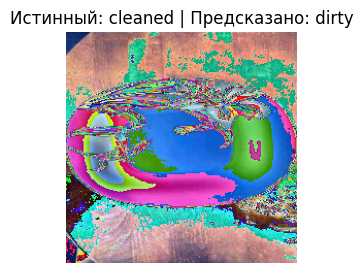

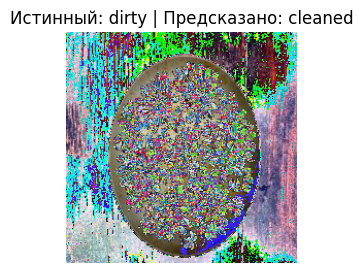

In [784]:
# Поcмотрим изображения, на которых модель ошиблась.

# Переводим модель в режим оценки
model.eval()

# Для вывода ошибок
errors_shown = 0
max_errors_to_show = 5  # Сколько показать максимум

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for j in range(images.size(0)):
            if preds[j] != labels[j] and errors_shown < max_errors_to_show:
                img_tensor = images[j].cpu()
                img = transforms.ToPILImage()(img_tensor)

                true_class = full_dataset.classes[labels[j].item()]
                pred_class = full_dataset.classes[preds[j].item()]

                plt.figure(figsize=(3, 3))
                plt.imshow(img)
                plt.title(f'Истинный: {true_class} | Предсказано: {pred_class}')
                plt.axis('off')
                plt.show()

                errors_shown += 1

        if errors_shown >= max_errors_to_show:
            break


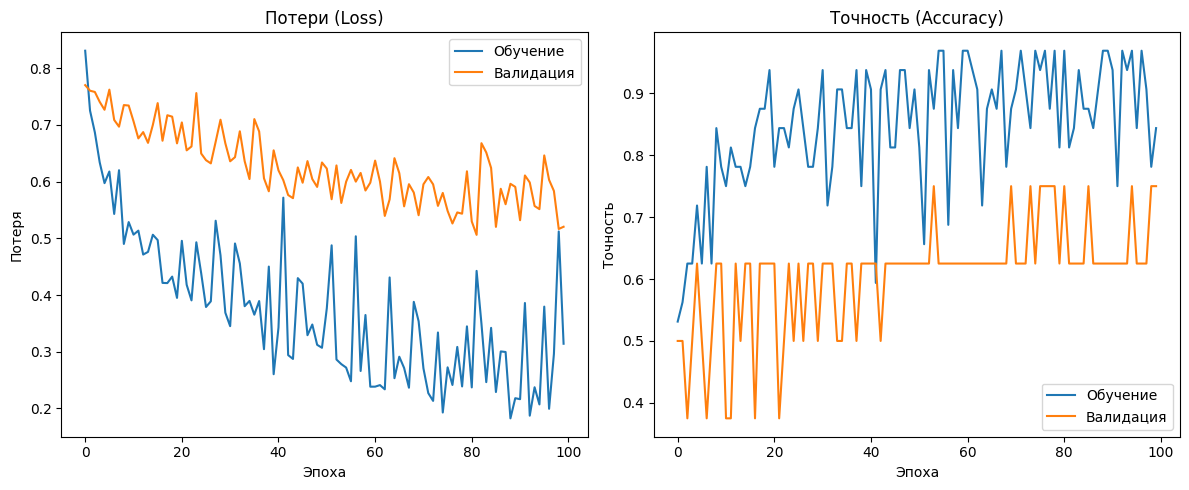

In [785]:
# Визуализация потерь и точности за все время обучения

# График потерь (Loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Обучение')
plt.plot(val_losses, label='Валидация')
plt.title('Потери (Loss)')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

# График точности (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Обучение')
plt.plot(val_accuracies, label='Валидация')
plt.title('Точность (Accuracy)')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()


### 5. Оценка и анализ результатов на тестовой выборке


In [786]:
# Подгружаем модель (предполагаем, что она уже обучена)
model.eval()  # Переводим модель в режим оценки (без обучения)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Загружаем все изображения из папки и делаем предсказания

image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)
               if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Для хранения предсказаний
predictions = []

# Пробегаемся по всем изображениям в папке
for img_path in image_paths:
    image = Image.open(img_path).convert('RGB')  # Открываем изображение и конвертируем в RGB
    input_tensor = val_transforms(image).unsqueeze(0)  # Применяем трансформации и добавляем batch dim
    input_tensor = input_tensor.to(device)  # Отправляем на нужное устройство (GPU/CPU)

    with torch.no_grad():  # Отключаем градиенты, так как нам не нужно обучение
        output = model(input_tensor)  # Прогоняем через модель
        _, pred = torch.max(output, 1)  # Получаем предсказание класса (индекс с максимальной вероятностью)
        predicted_class = pred.item()  # Преобразуем индекс в число

    # Добавляем результат в список
    predictions.append({
        "id": os.path.basename(img_path).replace(".jpg", "").replace(".jpeg", "").replace(".png", ""), 
        "label": "cleaned" if predicted_class == 0 else "dirty"
    })

# Преобразуем список в DataFrame
submission_df = pd.DataFrame(predictions)

# # Сохраняем в файл CSV для загрузки на Kaggle
# submission_df.to_csv("submission9.csv", index=False)

# Выводим результаты
for pred in predictions:
    img_name = pred['id']
    pred_class = pred['label']
    print(f"{img_name} → класс: {pred_class}")

0000 → класс: dirty
0001 → класс: dirty
0002 → класс: dirty
0003 → класс: dirty
0004 → класс: dirty
0005 → класс: dirty
0006 → класс: dirty
0007 → класс: dirty
0008 → класс: dirty
0009 → класс: dirty
0010 → класс: dirty
0011 → класс: dirty
0012 → класс: cleaned
0013 → класс: dirty
0014 → класс: cleaned
0015 → класс: dirty
0016 → класс: dirty
0017 → класс: dirty
0018 → класс: dirty
0019 → класс: dirty
0020 → класс: dirty
0021 → класс: dirty
0022 → класс: dirty
0023 → класс: cleaned
0024 → класс: dirty
0025 → класс: dirty
0026 → класс: dirty
0027 → класс: dirty
0028 → класс: cleaned
0029 → класс: dirty
0030 → класс: dirty
0031 → класс: dirty
0032 → класс: dirty
0033 → класс: dirty
0034 → класс: dirty
0035 → класс: dirty
0036 → класс: dirty
0037 → класс: dirty
0038 → класс: dirty
0039 → класс: dirty
0040 → класс: dirty
0041 → класс: dirty
0042 → класс: dirty
0043 → класс: dirty
0044 → класс: dirty
0045 → класс: dirty
0046 → класс: dirty
0047 → класс: dirty
0048 → класс: dirty
0049 → класс